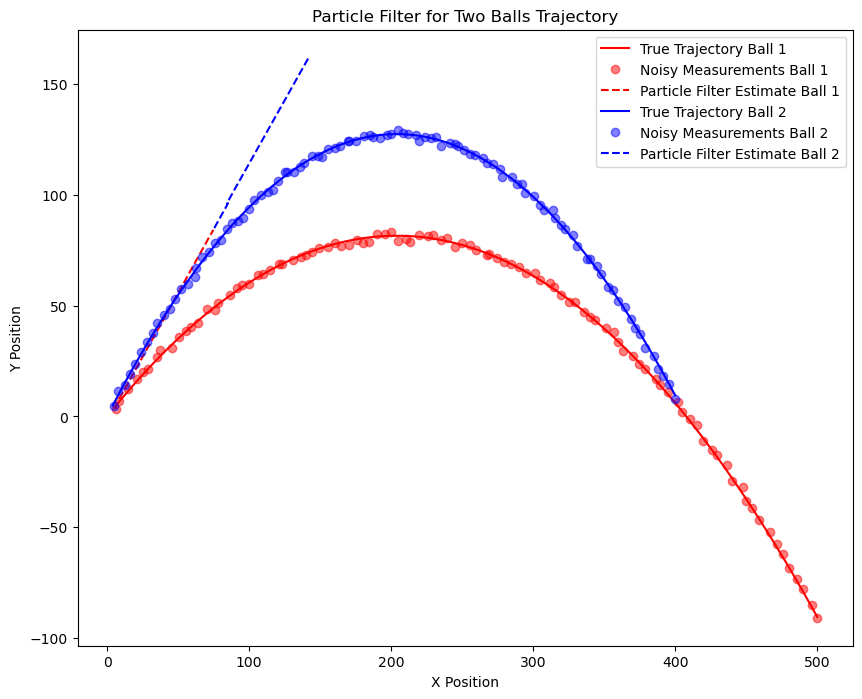

In [18]:
import numpy as np
import matplotlib.pyplot as plt

class ParticleFilter:
    def __init__(self, num_particles, dt, bounds, std_acc, std_meas):
        self.num_particles = num_particles
        self.dt = dt
        self.bounds = bounds
        self.std_acc = std_acc
        self.std_meas = std_meas
        self.particles = self.initialize_particles()
        self.weights = np.ones(self.num_particles) / self.num_particles

    def initialize_particles(self):
        particles = np.random.uniform(self.bounds[0], self.bounds[1], (self.num_particles, 4))
        return particles

    def predict(self):
        noise = np.random.normal(0, self.std_acc, self.particles.shape)
        self.particles[:, 0] += self.particles[:, 2] * self.dt + 0.5 * noise[:, 0] * self.dt ** 2
        self.particles[:, 1] += self.particles[:, 3] * self.dt + 0.5 * noise[:, 1] * self.dt ** 2
        self.particles[:, 2] += noise[:, 0] * self.dt
        self.particles[:, 3] += noise[:, 1] * self.dt

    def update(self, z):
        distances = np.linalg.norm(self.particles[:, :2] - z, axis=1)
        self.weights *= (1.0 / (np.sqrt(2 * np.pi * self.std_meas))) * np.exp(-distances**2 / (2 * self.std_meas**2))
        self.weights += 1.e-300  # Avoid zeros
        self.weights /= np.sum(self.weights)

    def resample(self):
        indices = np.random.choice(np.arange(self.num_particles), size=self.num_particles, p=self.weights)
        self.particles = self.particles[indices]
        self.weights = self.weights[indices]
        self.weights /= np.sum(self.weights)

    def estimate(self):
        return np.average(self.particles, weights=self.weights, axis=0)

    def simulate(self, z):
        estimates = []
        for measurement in z:
            self.predict()
            self.update(measurement)
            self.resample()
            estimates.append(self.estimate())
        return np.array(estimates)

def simulate_two_balls_trajectory(dt, total_time, initial_positions, initial_velocities, acc):
    num_steps = int(total_time / dt)
    trajectory = np.zeros((num_steps, 2, 2))  # Two balls, x and y positions
    vel = initial_velocities
    pos = initial_positions

    for i in range(num_steps):
        for j in range(2):
            pos[j] = pos[j] + vel[j] * dt + 0.5 * acc * dt ** 2
            vel[j] = vel[j] + acc * dt
            trajectory[i, j] = pos[j]
    return trajectory

def add_measurement_noise(trajectory, noise_std):
    noisy_trajectory = trajectory + np.random.normal(0, noise_std, trajectory.shape)
    return noisy_trajectory

# Simulation parameters
dt = 0.1
total_time = 10
initial_positions = [np.array([0, 0]), np.array([0, 0])]
initial_velocities = [np.array([50, 40]), np.array([40, 50])]
acc = np.array([0, -9.81])
measurement_noise_std = 1.0

# Simulate true trajectories
true_trajectories = simulate_two_balls_trajectory(dt, total_time, initial_positions, initial_velocities, acc)

# Add measurement noise
noisy_measurements = add_measurement_noise(true_trajectories, measurement_noise_std)

# Particle Filter parameters
pf = ParticleFilter(num_particles=1000, dt=dt, bounds=[-10, 10], std_acc=0.1, std_meas=measurement_noise_std)

# Run the Particle Filter
estimates = []
for i in range(2):  # Separate filters for each ball
    estimates.append(pf.simulate(noisy_measurements[:, i, :]))

# Plot results
plt.figure(figsize=(10, 8))
colors = ['r', 'b']
for i in range(2):
    plt.plot(true_trajectories[:, i, 0], true_trajectories[:, i, 1], label=f'True Trajectory Ball {i+1}', color=colors[i])
    plt.plot(noisy_measurements[:, i, 0], noisy_measurements[:, i, 1], 'o', label=f'Noisy Measurements Ball {i+1}', color=colors[i], alpha=0.5)
    plt.plot(estimates[i][:, 0], estimates[i][:, 1], label=f'Particle Filter Estimate Ball {i+1}', linestyle='--', color=colors[i])

plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Particle Filter for Two Balls Trajectory')
plt.legend()
plt.show()
